## **Introduction**  
In this notebook, we will implement model stacking to reduce the generalization error and improve our model. So far, we have created the following models:  
*  5_class_tree
*  5_class_tree_balanced
*  5_class_randomforest
*  5_class_XGBoost_Initial_Model
*  5_class_XGBoost

Model stacking can be understood as a more sophisticated version of cross-validation. We will be using a python package called vecstack ( https://github.com/vecxoz/vecstack) to automate the stacking process. The main idea behind a stacked generalization structure is to use one or more first-level models, make predictions using these models, and then use these predictions as features to fit one or more second-level models on top. To avoid overfitting, cross-validation is usually used to predict the OOF (out-of-fold) part of the training set. 

In [ ]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from numpy import mean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

## **Import Data**

In [ ]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 163, done.
remote: Total 163 (delta 0), reused 0 (delta 0), pack-reused 163
Receiving objects: 100% (163/163), 55.80 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   5_XGBoost.ipynb
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data
4_RandomForest.ipynb			   README.md


In [ ]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_test.csv')

In [ ]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

## **Import Models**

In [ ]:
import joblib

In [ ]:
xgb1 = joblib.load('/content/cloned-repo/NASA_TurboFan_Data/FD001/Models/5_class_XGBoost_Initial_Model')
xgb4 = joblib.load('/content/cloned-repo/NASA_TurboFan_Data/FD001/Models/5_class_XGBoost')
DTC = joblib.load('/content/cloned-repo/NASA_TurboFan_Data/FD001/Models/5_class_tree')
DTCbal = joblib.load('/content/cloned-repo/NASA_TurboFan_Data/FD001/Models/5_class_tree_balanced')
RndFor = joblib.load('/content/cloned-repo/NASA_TurboFan_Data/FD001/Models/5_class_randomforest')

## **Model Stacking**

In [ ]:
pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=8d29e9d0f836c55d8d2bfc9eb71f7f27d45ecdb16464ca56314088c889e1fc1b
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
from vecstack import stacking

### **First-Level Models**

In [ ]:
models = [
          DTC,
          DTCbal,
          RndFor,
          xgb1,
          xgb4
]

In [ ]:
S_train, S_test = stacking(models, X_train, y_train, X_test, regression=False,
                           mode='oof_pred_bag', needs_proba=False, metric=accuracy_score,
                           n_folds=4, shuffle=True, stratified=True, random_state=42, verbose=2)

task:         [classification]
n_classes:    [5]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.56829519]
    fold  1:  [0.55697205]
    fold  2:  [0.55903080]
    fold  3:  [0.56607807]
    ----
    MEAN:     [0.56259403] + [0.00471554]
    FULL:     [0.56259403]

model  1:     [DecisionTreeClassifier]
    fold  0:  [0.57082904]
    fold  1:  [0.55705123]
    fold  2:  [0.55728878]
    fold  3:  [0.56805765]
    ----
    MEAN:     [0.56330668] + [0.00621497]
    FULL:     [0.56330668]

model  2:     [RandomForestClassifier]
    fold  0:  [0.86000475]
    fold  1:  [0.85707499]
    fold  2:  [0.84567266]
    fold  3:  [0.85248238]
    ----
    MEAN:     [0.85380869] + [0.00540865]
    FULL:     [0.85380869]

model  3:     [XGBClassifier]
    fold  0:  [0.59640510]
    fold  1:  [0.59212923]
    fold  2:  [0.58444849]
    fold  3:  [0.58729907]
    ----
    MEAN:     [0.59007047] + [0.00457311]
    F

In [ ]:
final_model = xgb4
final_model = final_model.fit(S_train, y_train)

In [ ]:
y_pred = final_model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.83674404]


In [ ]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 8.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [ ]:
from yellowbrick.classifier import ClassificationReport

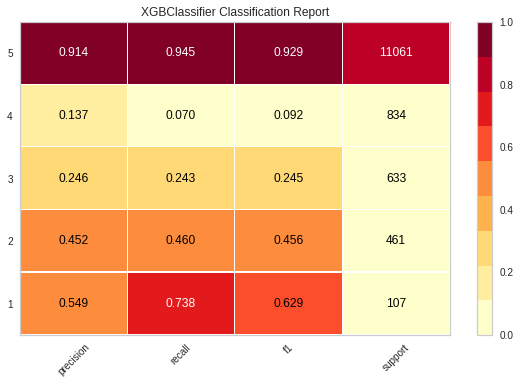

In [ ]:
viz = ClassificationReport((final_model), per_class=True, support=True)
viz.fit(S_train, y_train)
viz.score(S_test, y_test)
viz.show()